In [ ]:
!pip install contextily
!pip install pyrsgis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 48.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 kB 6.1 MB/s eta 0:00:00


In [ ]:
import contextily as cx
from ipywidgets import interact
from math import floor
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
from pyrsgis import raster
from pyrsgis.convert import array_to_table
from pyrsgis.ml import imageChipsFromArray
import random
import seaborn as sns
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from statistics import mean
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, Sequential

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# file names
feature_file = '/content/drive/MyDrive/Nadi_2013/2013_NDVI_NDWI_NDBI.tif'
# read the image
dsFeatures, arrFeatures = raster.read(feature_file, bands='all')
min_x = dsFeatures.bbox[0][0]
max_x = dsFeatures.bbox[1][0]
min_y = dsFeatures.bbox[0][1]
max_y = dsFeatures.bbox[1][1]

extent = [min_x, max_x, min_y, max_y]

In [ ]:
extent

[177.35465603830238,
 177.5796840169743,
 -17.874497860353415,
 -17.66024966509091]

In [ ]:
arrFeatures.shape

(10, 795, 835)

In [ ]:
import copy
from copy import deepcopy
from sklearn.feature_extraction import image

In [ ]:
def imageChipsFromSingleBandArray(data_arr, y_size=5, x_size=5):
    image_chips = deepcopy(data_arr)
    image_chips = np.pad(image_chips, (int(y_size/2),int(x_size/2)), 'reflect')
    image_chips = image.extract_patches_2d(image_chips, (y_size, x_size))

    return(image_chips)
def imageChipsFromArray_update(data_array, x_size=5, y_size=5):

    # if array is a single band image
    if len(data_array.shape) == 2:
        return(imageChipsFromSingleBandArray(data_array, x_size=x_size, y_size=y_size))

    # if array is a multi band image
    elif len(data_array.shape) > 2:
        data_array = copy.copy(data_array)
        data_array = np.rollaxis(data_array, 0, 3)

        for band in range(data_array.shape[2]):
            temp_array = imageChipsFromSingleBandArray(data_array[:, :, band], x_size=x_size, y_size=y_size)

            if band == 0:
                out_array = np.expand_dims(temp_array, axis=3)
            else:
                out_array = np.concatenate((out_array, np.expand_dims(temp_array, axis=3)), axis=3)

        return(out_array)

    # if shape of the image is less than two dimensions, raise error
    else:
        raise Exception("Sorry, only two or three dimensional arrays allowed.")

In [ ]:
# normalize the image and generate chips
arrFeatures_fuzzy = np.zeros(arrFeatures.shape)

for i in range(arrFeatures.shape[0]):
    bandMin = arrFeatures[i, :, :].min()
    bandMax = arrFeatures[i, :, :].max()
    bandRange = bandMax-bandMin
    for j in range(arrFeatures.shape[1]):
        for k in range(arrFeatures.shape[2]):
            arrFeatures_fuzzy[i, j, k] = (arrFeatures[i, j, k]-bandMin)/bandRange

#create chips using pyrsgis
#features_chips = imageChipsFromArray(arrFeatures_fuzzy, x_size=7, y_size=7)
features_chips = imageChipsFromArray_update(arrFeatures_fuzzy, x_size=9, y_size=9)

In [ ]:
features_chips.shape

(663825, 9, 9, 10)

*****

**2013_Training datast**

In [ ]:
positiveLabel_file = '/content/drive/MyDrive/Nadi_2013/Label_2013_1117.tif'
dsPositiveLabels, arrPositiveLabels = raster.read(positiveLabel_file,bands='all')
n_class_pos = len(np.unique(arrPositiveLabels))

In [ ]:
n_class_pos

8

In [ ]:
arrPositiveLabels=arrPositiveLabels+1
np.unique(arrPositiveLabels)

array([0., 1., 2., 3., 4., 5., 6., 7.])

In [ ]:
# generate random samples
nonZero_count = np.count_nonzero(arrPositiveLabels)
index = np.transpose(np.where(arrPositiveLabels==0))
index = index.astype(int)
randomIndex = random.sample(range(index.shape[0]), int(nonZero_count/(n_class_pos-1)))
arrNegativeLabels = np.zeros(arrPositiveLabels.shape)

for i in range(len(randomIndex)):
    arrNegativeLabels[index[randomIndex[i], 0], index[randomIndex[i], 1]] = n_class_pos # max value of labels plus one which equals n_class

arrPositiveLabels_flat = arrPositiveLabels.flatten()
arrNegativeLabels_flat = arrNegativeLabels.flatten()
# separate and balance the classes
positiveFeatures = features_chips[arrPositiveLabels_flat!=0]
positiveLabels = arrPositiveLabels_flat[arrPositiveLabels_flat!=0]

features=positiveFeatures
labels=positiveLabels

In [ ]:
 len(features_chips[arrPositiveLabels_flat==6])

91

In [ ]:
from sklearn.utils import resample
coastal_upsample = resample(features_chips[arrPositiveLabels_flat==6],
             replace=True,
             n_samples=159,
             random_state=42)

In [ ]:
arr = np.concatenate((features, coastal_upsample), axis=0)

In [ ]:
features=arr
coastal_label=[6]*159
new_label=np.concatenate((labels,coastal_label),axis=0)
labels=new_label
labels=labels-1

In [ ]:
n_class_pos = len(np.unique(labels))
print(n_class_pos)

7


In [ ]:
labels_df=pd.DataFrame()
labels_df['labels']=labels
labels_df['labels'].value_counts()

2.0    250
4.0    250
1.0    250
6.0    250
0.0    250
5.0    250
3.0    250
Name: labels, dtype: int64

****

**Split**

In [ ]:
# # define a function to split features and labels
def train_test_split(features, labels, n_class_pos=n_class_pos, trainProp=0.7):
    labels_df=pd.DataFrame()
    labels_df['labels']=labels
    labels_df.reset_index(inplace=True)
    labels_df['labels']=labels_df['labels'].astype(int)

    train_list=[]
    test_list=[]
    for class_index in range(n_class_pos):
      sub_labels_df=labels_df[labels_df['labels'] == class_index ]
      dataSize=len(sub_labels_df['index'])
      sliceIndex = int(dataSize*trainProp)
      randIndex = list(sub_labels_df['index'])
      #random.seed(45)
      random.shuffle(randIndex)

      sub_train_list=randIndex[:sliceIndex]
      train_list = train_list + sub_train_list

      sub_test_list=randIndex[sliceIndex:]
      test_list = test_list + sub_test_list

    train_x = features[[train_list], :, :, :][0]
    test_x = features[[test_list], :, :, :][0]
    train_y = labels[train_list]
    test_y = labels[test_list]
    return(train_x, train_y, test_x, test_y)

# call the function to split the dataset
train_x, train_y, test_x, test_y = train_test_split(features, labels)

In [ ]:
train_y_df=pd.DataFrame()
train_y_df['labels']=train_y
train_y_df['labels'].value_counts()

0.0    175
1.0    175
2.0    175
3.0    175
4.0    175
5.0    175
6.0    175
Name: labels, dtype: int64

In [ ]:
test_y_df=pd.DataFrame()
test_y_df['labels']=test_y
test_y_df['labels'].value_counts()

0.0    75
1.0    75
2.0    75
3.0    75
4.0    75
5.0    75
6.0    75
Name: labels, dtype: int64

****

In [ ]:
175*7

1225

**Model**

In [ ]:
from keras.layers import Dense, Flatten
from keras.utils import to_categorical

In [ ]:
print(f"train_x.shape: {train_x.shape}")
print(f"train_y.shape: {train_y.shape}")
print(f"test_x.shape: {test_x.shape}")
print(f"test_y.shape: {test_y.shape}")

train_x.shape: (1225, 9, 9, 10)
train_y.shape: (1225,)
test_x.shape: (525, 9, 9, 10)
test_y.shape: (525,)


In [ ]:
X_train_mlp = train_x.reshape((1225, 9*9*10))
X_test_mlp = test_x.reshape((525, 9*9*10))
y_train_mlp = to_categorical(train_y)
y_test_mlp = to_categorical(test_y)

In [ ]:
def roc_auc(model, X_test_mlp, y_test_mlp, n_classes):
    roc_auc = []
    test_z = model.predict(X_test_mlp)
    test_y_dummies = y_test_mlp

    for i in range(n_classes):
        roc_auc.append(roc_auc_score(test_y_dummies[:, i], test_z[:, i]))

    return roc_auc

In [ ]:
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics)+1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and Testing '+metric.capitalize())
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend(['Training '+metric.capitalize(), 'Testing '+metric.capitalize()])
    plt.show()

*****

****

Epoch 1/100
39/39 [==============================] - 2s 16ms/step - loss: 1.6415 - accuracy: 0.4294 - val_loss: 1.4433 - val_accuracy: 0.5657
Epoch 2/100
39/39 [==============================] - 0s 8ms/step - loss: 1.3079 - accuracy: 0.5812 - val_loss: 1.1798 - val_accuracy: 0.6343
Epoch 3/100
39/39 [==============================] - 0s 8ms/step - loss: 1.1049 - accuracy: 0.6392 - val_loss: 1.0238 - val_accuracy: 0.6800
Epoch 4/100
39/39 [==============================] - 0s 5ms/step - loss: 0.9742 - accuracy: 0.6702 - val_loss: 0.9236 - val_accuracy: 0.7067
Epoch 5/100
39/39 [==============================] - 0s 5ms/step - loss: 0.8626 - accuracy: 0.7404 - val_loss: 0.8300 - val_accuracy: 0.7695
Epoch 6/100
39/39 [==============================] - 0s 6ms/step - loss: 0.7989 - accuracy: 0.7543 - val_loss: 0.7541 - val_accuracy: 0.7562
Epoch 7/100
39/39 [==============================] - 0s 4ms/step - loss: 0.7443 - accuracy: 0.7543 - val_loss: 0.7373 - val_accuracy: 0.6838
Epoch 8/100


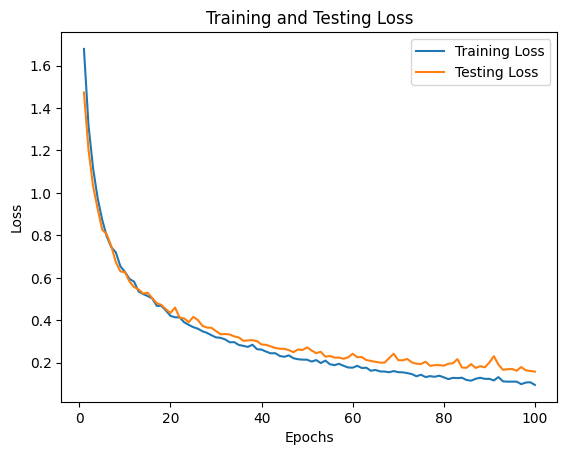

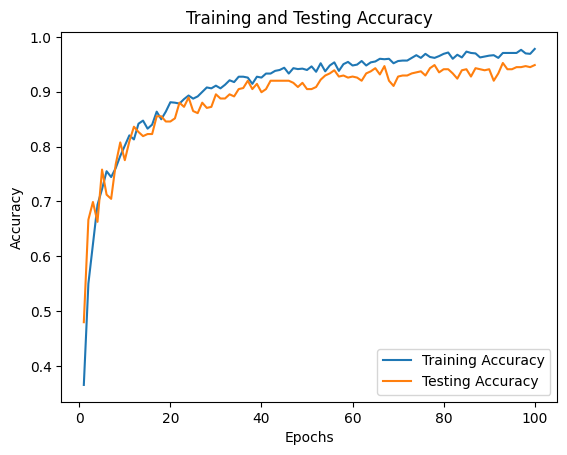

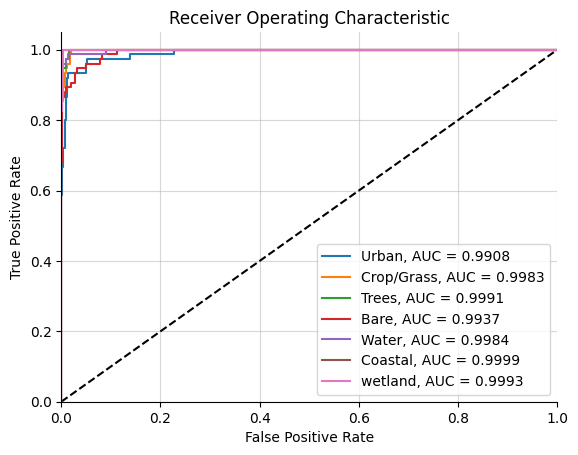

ROC AUC score: 0.9970708994708994


In [ ]:
def roc_plot(test_y, test_z, n_classes, labels_name, average='macro'):
    fpr = {}
    tpr = {}
    roc_auc = {}

    test_y_dummies = y_test_mlp
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(test_y_dummies[:, i], test_z[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    # roc for each class
    fig, ax = plt.subplots()
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic')

    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='{}, AUC = {}'.format(labels_name[i], '{0:.4f}'.format(roc_auc[i])))

    ax.legend(loc='best')
    ax.grid(alpha=0.5)
    sns.despine()
    plt.show()
    print('ROC AUC score:', roc_auc_score(test_y_dummies, test_z, average=average))

best_model = tf.keras.models.Sequential()
best_accuracy = 0
best_history = None

experimental_runs = 10
cv = 10
metrics_columns = ['Accuracy', 'Precision', 'Recall', 'F1 Score','AUC_Urban','AUC_Crop/Grass','AUC_Trees','AUC_Bare','AUC_Water','AUC_Coastal','AUC_wetland','Roc_auc_mean']
temp_metrics_df = pd.DataFrame(np.zeros((cv, len(metrics_columns))), columns=metrics_columns)

################################### Model ###################################################

for i in range(experimental_runs):

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(X_train_mlp.shape[1], )))

    model.add(tf.keras.layers.Dense(32, activation='relu'))


    model.add(tf.keras.layers.Dense(7, activation='softmax'))

    model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
    history=model.fit(X_train_mlp, y_train_mlp, epochs=100, batch_size=32, validation_data=(X_test_mlp, y_test_mlp))


    for j in range(cv):

        test_z = model.predict(X_test_mlp)
        test_z_class = test_z.argmax(axis=1)

        aScore = accuracy_score(test_y, test_z_class)
        pScore = precision_score(test_y, test_z_class, average='macro')
        rScore = recall_score(test_y, test_z_class, average='macro')
        fScore = f1_score(test_y, test_z_class, average='macro')
        cMatrix = confusion_matrix(test_y, test_z_class)
        metrics_array = [aScore, pScore, rScore, fScore]

        roc_auc_class = roc_auc(model, X_test_mlp, y_test_mlp, n_class_pos)



        for k in range(n_class_pos):
            metrics_array.append(roc_auc_class[k])

        roc_auc_mean = mean(roc_auc_class)
        metrics_array.append(roc_auc_mean)
        temp_metrics_df.loc[j] = metrics_array
        if j==cv-1:
            # accuracy can be replaced with other scores
            aScore_avg = temp_metrics_df['Accuracy'].mean()

            if best_accuracy < aScore_avg:
                best_model = model
                best_accuracy_avg = aScore_avg
                best_history = history

print(f'\nBest Average Accuracy: {best_accuracy_avg}')
test_z = best_model.predict(X_test_mlp)

roc_auc_class = roc_auc(model, X_test_mlp, y_test_mlp,n_class_pos)
metrics_array.extend(roc_auc_class)
roc_auc_mean = mean(roc_auc_class)
metrics_array.append(roc_auc_mean)

print(f'\nConfusion Matrix:\n{cMatrix}')
print(f'\nAccuracy: {aScore}')
print(f'\nPrecision: {pScore}')
print(f'\nRecall: {rScore}')
print(f'\nF1 Score: {fScore}')

plot_metric(history, 'loss')
print('')
plot_metric(history, 'accuracy')


labels_name = ['Urban','Crop/Grass','Trees','Bare','Water','Coastal','wetland'] #Labels name should be the same with the class
roc_plot(test_y, test_z, n_class_pos, labels_name)

*****

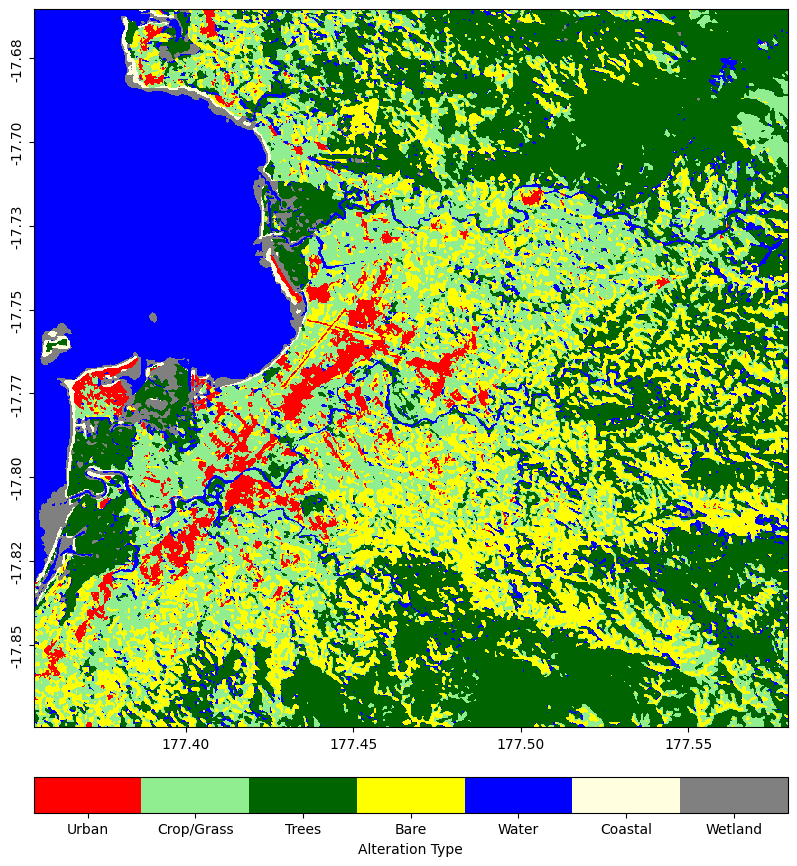

In [ ]:
fig, ax = plt.subplots(figsize=(795/80, 835/80))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
cmap = mpl.colors.ListedColormap(['red','lightgreen','darkgreen','yellow','blue','lightyellow','gray'])
image = plt.imshow(features_chips_prediction_arr_Nadi_2013, cmap=cmap, extent=extent, interpolation='nearest')
divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
cbar = plt.colorbar(image, orientation='horizontal', label='Alteration Type', cax=cax)
tick_locs = (np.arange(n_class_pos)+0.5)*(n_class_pos-1)/n_class_pos
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(['Urban', 'Crop/Grass', 'Trees', 'Bare', 'Water','Coastal','Wetland'])
plt.grid(False)